In [1]:
from neuron import h, gui
from neuron.units import ms, mV

h.load_file("stdrun.hoc")
import numpy as np
import random

In [2]:
class Cell:
    def __init__(self, gid, x, y, z, theta):
        self._gid = gid
        self._setup_morphology()
        self.all = self.soma.wholetree()
        self._setup_biophysics()
        self.x = self.y = self.z = 0
        h.define_shape()
        self._rotate_z(theta)
        self._set_position(x, y, z)

        # everything below here in this method is NEW
        self._spike_detector = h.NetCon(self.soma(0.5)._ref_v, None, sec=self.soma)
        self.spike_times = h.Vector()
        self._spike_detector.record(self.spike_times)

        self._ncs = []

        self.soma_v = h.Vector().record(self.soma(0.5)._ref_v)

    def __repr__(self):
        return "{}[{}]".format(self.name, self._gid)

    def _set_position(self, x, y, z):
        for sec in self.all:
            for i in range(sec.n3d()):
                sec.pt3dchange(
                    i,
                    x - self.x + sec.x3d(i),
                    y - self.y + sec.y3d(i),
                    z - self.z + sec.z3d(i),
                    sec.diam3d(i),
                )
        self.x, self.y, self.z = x, y, z

    def _rotate_z(self, theta):
        """Rotate the cell about the Z axis."""
        for sec in self.all:
            for i in range(sec.n3d()):
                x = sec.x3d(i)
                y = sec.y3d(i)
                c = h.cos(theta)
                s = h.sin(theta)
                xprime = x * c - y * s
                yprime = x * s + y * c
                sec.pt3dchange(i, xprime, yprime, sec.z3d(i), sec.diam3d(i))

In [3]:
class BallAndStick(Cell):
    name = "BallAndStick"

    def _setup_morphology(self):
        self.soma = h.Section(name="soma", cell=self)
        self.dend = h.Section(name="dend", cell=self)
        self.dend.connect(self.soma)
        self.soma.L = self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1

    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100  # Axial resistance in Ohm * cm
            sec.cm = 1  # Membrane capacitance in micro Farads / cm^2
        self.soma.insert("hh")
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003  # Leak conductance in S/cm2
            seg.hh.el = -54.3  # Reversal potential in mV
        # Insert passive current in the dendrite
        self.dend.insert("pas")
        for seg in self.dend:
            seg.pas.g = 0.001  # Passive conductance in S/cm2
            seg.pas.e = -65  # Leak reversal potential mV

        # NEW: the synapse
        self.syn = h.ExpSyn(self.dend(0.5))
        self.syn.tau = 2 * ms

In [4]:
a = np.zeros((5,5))
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        a[i, j] = 10 * i + j
for i in range(a.shape[0]):
    a[i, i] = 0
prob = a[1, :] / a[1,:].sum()

# random.random()

In [5]:
prob

array([0.20408163, 0.        , 0.24489796, 0.26530612, 0.28571429])

In [6]:
class Network():

    def __init__(
        self, cell_type = BallAndStick, position_info = None, connection_mat = None, stim_w=0.04, stim_t=9, stim_delay=1, syn_w=0.01, syn_delay=5
    ):
        """
        :param N: Number of cells.
        :param stim_w: Weight of the stimulus
        :param stim_t: time of the stimulus (in ms)
        :param stim_delay: delay of the stimulus (in ms)
        :param syn_w: Synaptic weight
        :param syn_delay: Delay of the synapse
        :param r: radius of the network
        """
        self._syn_w = syn_w
        self._syn_delay = syn_delay
        
        self._create_cells(cell_type, position_info)
        self._connection = np.zeros((len(self.cells), len(self.cells)))
        self._connect_cells(connection_mat)
        # add stimulus
        self._netstim = h.NetStim()
        self._netstim.number = 1
        self._netstim.start = stim_t
        self._nc = h.NetCon(self._netstim, self.cells[0].syn)
        self._nc.delay = stim_delay
        self._nc.weight[0] = stim_w

    def _create_cells(self, cell_type, position_info):
        self.cells = []
        if (position_info is not None):
            for i in range(len(position_info)):
                self.cells.append(cell_type(i, position_info[i]['x'], position_info[i]['y'], position_info[i]['z'], position_info[i]['theta']))
        else:
            N = 5
            r = 50
            for i in range(N):
                theta = i * 2 * h.PI / N
                self.cells.append(
                    BallAndStick(i, h.cos(theta) * r, h.sin(theta) * r, 0, theta)
                )
                

    def _connect_cells(self, connection_mat):
        if (connection_mat is not None):
            for i in range(connection_mat.shape[0]):
                for j in range(connection_mat.shape[1]):
                    if connection_mat[i, j] == 1:
                        source, target = self.cells[i], self.cells[j]
                        nc = h.NetCon(source.soma(0.5)._ref_v, target.syn, sec=source.soma)
                        nc.weight[0] = self._syn_w
                        nc.delay = self._syn_delay
                        source._ncs.append(nc)
            self._connection = connection_mat
        else:
            print('No distance given')
            dist_mat = self._cal_cell_distance()
            for i in range(len(self.cells)):
                random_prob = random.random()
                prob = dist_mat[i, :] / dist_mat[i,:].sum()
                for j in range(len(self.cells)):
                    random_prob = random_prob - prob[j]
                    if random_prob <= 0:
                        source, target = self.cells[i], self.cells[j]
                        nc = h.NetCon(source.soma(0.5)._ref_v, target.syn, sec=source.soma)
                        nc.weight[0] = self._syn_w
                        nc.delay = self._syn_delay
                        source._ncs.append(nc)
                        self._connection[i, j] = 1 
                        break
                
            
    def _cal_cell_distance(self):
        cell_count = len(self.cells)
        dist_mat = np.zeros((cell_count, cell_count))
        for i in range(cell_count):
            for j in range(cell_count):
                if i != j:
                    dist_mat[i, j] = np.sqrt((self.cells[i].x - self.cells[j].x) ** 2 + (self.cells[i].y - self.cells[j].y) ** 2 + (self.cells[i].z - self.cells[j].z) ** 2)
                else:
                    dist_mat[i, j] = 0
        return dist_mat

        
            

In [7]:
# connection_mat = np.array([[0, 1, 0, 0, 0],
#                            [0, 0, 1, 0, 0],
#                            [0, 0, 0, 1, 0],
#                            [0, 0, 0, 0, 1],
#                            [1, 0, 0, 0, 0]])
connection_mat = None

cell = BallAndStick


position_info = []
N = 5
r = 50
for i in range(N):
    theta = i * 2 * h.PI / N
    x = h.cos(theta) * r
    y =  h.sin(theta) * r
    z = 0
    singal_info = {'x': x, 'y': y, 'z':z, 'theta':theta}
    position_info.append(singal_info)

# position_info = [{"x": 150, "y": -80, "z": 20, "theta" : 2 * h.PI }, 
#                  {"x": 10, "y": 100, "z": 60, "theta": 0 * h.PI },
#                  {"x": -50, "y": 70, "z": 0, "theta":  1.7 * h.PI},
#                  {"x": 60, "y": -100, "z": -30, "theta": 1.2 * h.PI },
#                  {"x": 0, "y": 0, "z": -30, "theta":  0.5 * h.PI }]
    


    

In [8]:
ring = Network(BallAndStick, position_info, connection_mat)

No distance given


In [9]:
ring._connection


array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])

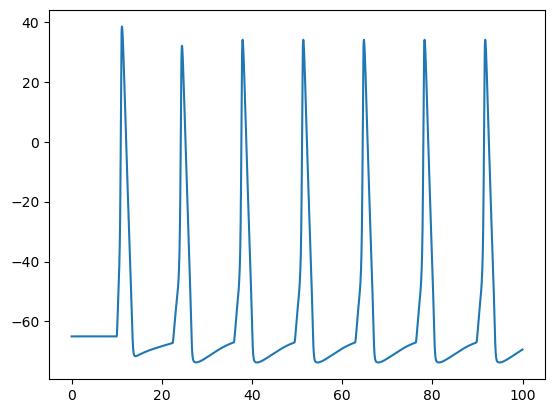

In [10]:
shape_window = h.PlotShape(True)
shape_window.show(0)

t = h.Vector().record(h._ref_t)
h.finitialize(-65 * mV)
h.continuerun(100)

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(t, ring.cells[0].soma_v)
plt.show()



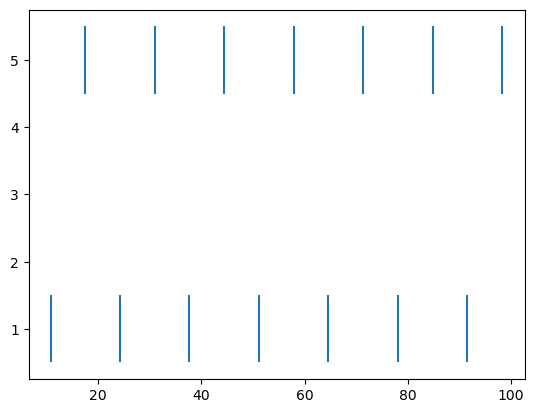

In [11]:
plt.figure()
for i, cell in enumerate(ring.cells):
    # print(i, cell.spike_times)
    if len(cell.spike_times) > 0:
        plt.vlines(cell.spike_times, i + 0.5, i + 1.5)
plt.show()